# CNN solubility
Tokenize SMILES, train the 1D CNN baseline, and export predictions and plots.


In [2]:
import json
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

sys.path.append(os.path.join("..", "src"))
from cnn_utils import SmilesCNN, SmilesDataset, build_vocab, encode_smiles, evaluate
from viz_utils import parity_plot, plot_loss_curve, residual_hist

train = pd.read_csv("../data/train.csv")
val = pd.read_csv("../data/val.csv")
test = pd.read_csv("../data/test.csv")


/Users/amrithaa/cse2371-qnn/solubility/notebooks/../src/cnn_utils.py:13: FutureWarning: Possible nested set at position 14
  TOKENIZER_RE = re.compile(r"(\\%\\d{2}|\\[[^\\]]+\\]|Br|Cl|.)")


In [3]:
# Tokenizer and datasets
stoi, itos = build_vocab(train["SMILES"].tolist())
with open("../artifacts/vocab.json", "w") as f:
    json.dump(itos, f)

MAX_LEN = 256
BATCH = 128
LR = 2e-3
EPOCHS = 40
DROPOUT = 0.2

train_ds = SmilesDataset(train.SMILES, train.Solubility, stoi, MAX_LEN)
val_ds = SmilesDataset(val.SMILES, val.Solubility, stoi, MAX_LEN)
test_ds = SmilesDataset(test.SMILES, test.Solubility, stoi, MAX_LEN)

train_ld = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_ld = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_ld = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


In [4]:
# Train loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmilesCNN(vocab_size=len(itos), emb_dim=128, max_len=MAX_LEN, dropout=DROPOUT).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
crit = nn.MSELoss()

hist = {"epoch": [], "train_loss": [], "val_rmse": []}
best_rmse, best_state, patience, waited = float("inf"), None, 8, 0

for ep in range(1, EPOCHS + 1):
    model.train()
    losses = []
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()
        losses.append(loss.item())
    rmse, mae, r2 = evaluate(model, val_ld, device)
    hist["epoch"].append(ep)
    hist["train_loss"].append(float(np.mean(losses)))
    hist["val_rmse"].append(rmse)
    print(f"Ep{ep:02d} loss {np.mean(losses):.4f} | val RMSE {rmse:.3f}")
    if rmse < best_rmse - 1e-4:
        best_rmse, best_state, waited = rmse, {k: v.cpu() for k, v in model.state_dict().items()}, 0
    else:
        waited += 1
        if waited >= patience:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    torch.save(best_state, "../artifacts/best_cnn.pt")


Ep01 loss 5.9131 | val RMSE 2.203
Ep02 loss 3.0859 | val RMSE 1.783
Ep03 loss 2.5676 | val RMSE 1.782
Ep04 loss 2.3125 | val RMSE 1.651
Ep05 loss 2.0839 | val RMSE 1.583
Ep06 loss 1.9845 | val RMSE 1.633
Ep07 loss 1.8913 | val RMSE 1.715
Ep08 loss 1.8270 | val RMSE 1.577
Ep09 loss 1.8262 | val RMSE 1.645
Ep10 loss 1.6754 | val RMSE 1.681
Ep11 loss 1.5700 | val RMSE 1.682
Ep12 loss 1.7303 | val RMSE 1.583
Ep13 loss 1.6560 | val RMSE 1.608
Ep14 loss 1.4926 | val RMSE 1.571
Ep15 loss 1.5357 | val RMSE 1.535
Ep16 loss 1.4511 | val RMSE 1.542
Ep17 loss 1.6260 | val RMSE 1.583
Ep18 loss 1.4128 | val RMSE 1.653
Ep19 loss 1.5340 | val RMSE 1.545
Ep20 loss 1.3686 | val RMSE 1.539
Ep21 loss 1.3592 | val RMSE 1.557
Ep22 loss 1.3053 | val RMSE 1.510
Ep23 loss 1.4077 | val RMSE 1.515
Ep24 loss 1.3449 | val RMSE 1.489
Ep25 loss 1.2726 | val RMSE 1.490
Ep26 loss 1.2247 | val RMSE 1.593
Ep27 loss 1.2682 | val RMSE 1.583
Ep28 loss 1.3190 | val RMSE 1.671
Ep29 loss 1.3630 | val RMSE 1.571
Ep30 loss 1.24

In [5]:
# Metrics and predictions
tr_rmse, tr_mae, tr_r2 = evaluate(model, train_ld, device)
va_rmse, va_mae, va_r2 = evaluate(model, val_ld, device)
te_rmse, te_mae, te_r2 = evaluate(model, test_ld, device)
print("Train:", tr_rmse, tr_mae, tr_r2)
print("Val:", va_rmse, va_mae, va_r2)
print("Test:", te_rmse, te_mae, te_r2)

ys, ps = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_ld:
        ys.append(yb.numpy())
        ps.append(model(xb.to(device)).cpu().numpy())
y_test = np.concatenate(ys)
y_pred = np.concatenate(ps)

pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(
    "../results/cnn_test_predictions.csv", index=False
)


Train: 0.9111043810844421 0.6390045285224915 0.8734806180000305
Val: 1.554887056350708 1.1914279460906982 0.6298469305038452
Test: 1.5390212535858154 1.163476824760437 0.6563145518302917


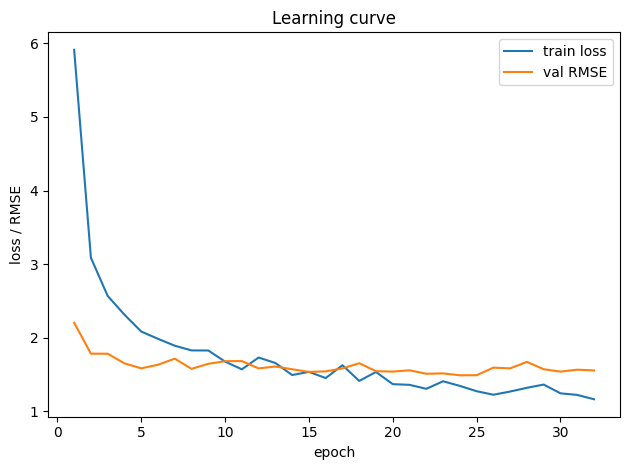

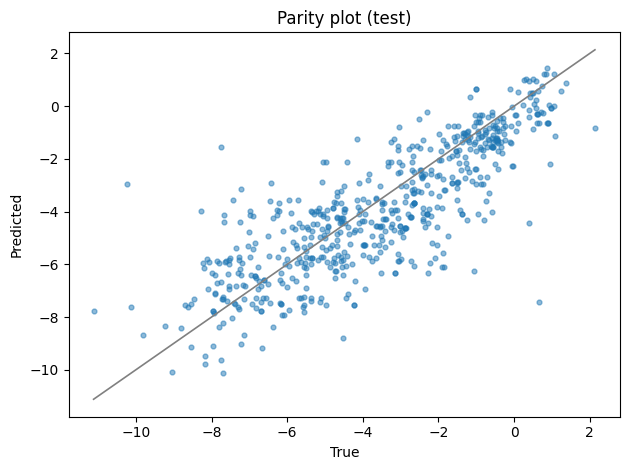

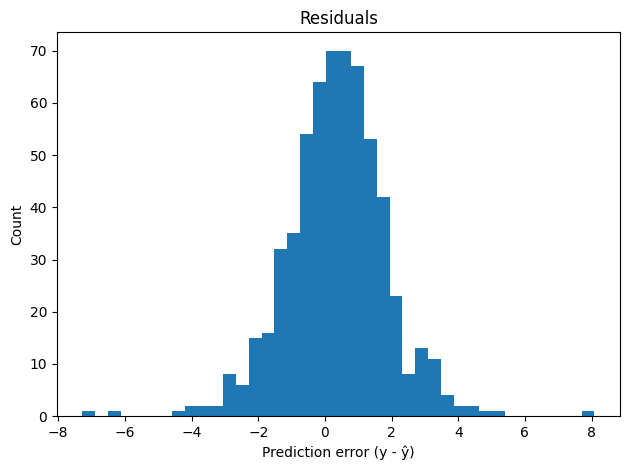

In [6]:
# Visuals
plot_loss_curve(hist)
parity_plot(y_test, y_pred, title="Parity plot (test)")
residual_hist(y_test - y_pred)


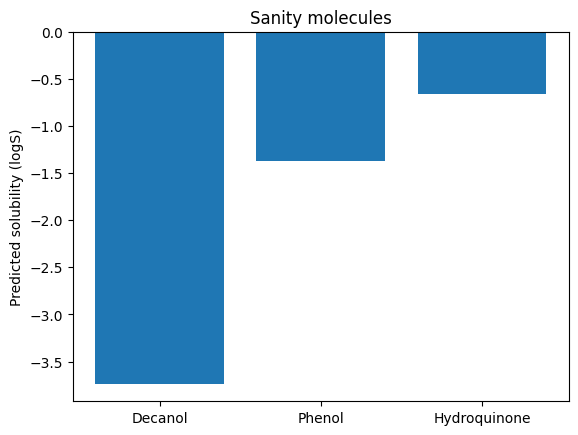

In [7]:
# Sanity molecules
def predict_smiles(smiles_list):
    xs = [encode_smiles(s, stoi, MAX_LEN) for s in smiles_list]
    xb = torch.tensor(np.stack(xs))
    with torch.no_grad():
        return model(xb.to(device)).cpu().numpy()

decanol = "CCCCCCCCCCO"
phenol = "c1ccc(cc1)O"
hydroquinone = "Oc1ccc(cc1)O"

names = ["Decanol", "Phenol", "Hydroquinone"]
vals = predict_smiles([decanol, phenol, hydroquinone])
plt.figure()
plt.bar(names, vals)
plt.ylabel("Predicted solubility (logS)")
plt.title("Sanity molecules")
plt.show()
